# 1. Get data from wikipedia

In [1]:
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
import numpy as np
import json
import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import matplotlib.pyplot as plt

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
dfs = pd.read_html(url)
print(len(dfs))

3


In [2]:
df =dfs[0]
print(df.shape)

#Data from wikipedia for Toronto neighbourhood
df.head()

(180, 3)


,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


# 2. Filter out a borough that is 'Not assigned' 

In [3]:
df2 = df.loc[df['Borough'] != 'Not assigned']
df2.reset_index(drop = True, inplace = True)
df2.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
df2.shape

(103, 3)

# 3. Get geographical coordinates of each postal code

### The lattitude and longitude for Post Code column are taken from https://cocl.us/Geospatial_data csv file.

In [5]:
#read Geospatial_Coordinates.csv downloaded from https://cocl.us/Geospatial_data

geo = pd.read_csv('Geospatial_Coordinates.csv')
geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Dataframe for boroughs with latitude and longitude

In [6]:
#use inner join to merge the Toronto neighborhood dataframe with geographical dataframe


df_toronto = pd.merge(df2,geo, on = 'Postal Code', how = 'inner')
df_toronto.head(10)

print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_toronto['Borough'].unique()),
        df_toronto.shape[0]
    )
)
df_toronto.head()

The dataframe has 10 boroughs and 103 neighborhoods.


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [141]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_a = df_toronto
toronto_area = toronto_a.join(toronto_borough.set_index('Borough'), on='Borough')

toronto_area.head() 
#downtown_data1.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Area
0,M3A,North York,Parkwoods,43.753259,-79.329656,0
1,M4A,North York,Victoria Village,43.725882,-79.315572,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1


# 4. Let's get the geographical coordinates of Toronto

In [7]:
CLIENT_ID = 'F3B1JWD3I3HZXSNGMMSV42XNHW4YCMBQWNOIP34GXPS4CZLP' # your Foursquare ID
CLIENT_SECRET = '0WIV2KKM2ZOC05CJTHMUG2RDL1EKJ0PRCHUVNRMYXEPJCYRQ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: F3B1JWD3I3HZXSNGMMSV42XNHW4YCMBQWNOIP34GXPS4CZLP
CLIENT_SECRET:0WIV2KKM2ZOC05CJTHMUG2RDL1EKJ0PRCHUVNRMYXEPJCYRQ


In [8]:
import geopy
from geopy.geocoders import Nominatim

# define the city and get its latitude & longitude 
city = 'Toronto'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(city)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
#print(latitude, longitude)

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


# 5.Create map of Toronto using latitude and longitude values

In [9]:
# create map of Toronto using latitude and longitude values
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_toronto['Latitude'], df_toronto['Longitude'],\
                                           df_toronto['Borough'], df_toronto['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# 6. Get data for Downtown Toronto as requested by our clients

In [10]:
downtown_toronto = df_toronto[df_toronto['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


# 7. Get the geographical coordinates of Downtown Toronto

In [11]:
borough = 'Downtown Toronto'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(borough)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))


The geograpical coordinate of Downtown Toronto are 43.6541737, -79.38081164513409.


# 8. Create map of Downtown Toronto using latitude and longitude values

In [12]:
# create map of Downtown Toronto using latitude and longitude values
map_downtown = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downtown_toronto['Latitude'], downtown_toronto['Longitude'],\
                           downtown_toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown)  
    
map_downtown

# 9. Explore Neighbourhoods in Downtown Toronto

In [30]:
radius = 500
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## List of neighbourhood areas in Downtown Toronto

In [31]:
downtown_venues = getNearbyVenues(names=downtown_toronto['Neighbourhood'],
                                   latitudes=downtown_toronto['Latitude'],
                                   longitudes=downtown_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [16]:
unique_n = downtown_venues['Neighbourhood'].unique()
downtown_n = pd.DataFrame(unique_n)
downtown_n.rename(columns = {0: 'Neighbourhood'}, inplace = True)
downtown_n

,Neighbourhood
0,"Regent Park, Harbourfront"
1,"Queen's Park, Ontario Provincial Government"
2,"Garden District, Ryerson"
3,St. James Town
4,Berczy Park
5,Central Bay Street
6,Christie
7,"Richmond, Adelaide, King"
8,"Harbourfront East, Union Station, Toronto Islands"
9,"Toronto Dominion Centre, Design Exchange"


### There are 19 neighbourhood areas in Downtown Toronto

## List of venues for each neighborhood taken from Foursquare

In [32]:
print(downtown_venues.shape)
downtown_venues.head()

(1242, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [33]:
print('There are {} uniques categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 209 uniques categories.


## Number of venues category in each neigborhood

In [20]:
dt_n = downtown_venues.groupby(['Neighbourhood']).size()
dt_venues = pd.DataFrame(dt_n)
dt_venues.rename(columns = {0:'Venue'},inplace = True)
dt_venues.reset_index(inplace = True)

dt_venues

,Neighbourhood,Venue
0,Berczy Park,58
1,"CN Tower, King and Spadina, Railway Lands, Har...",15
2,Central Bay Street,63
3,Christie,16
4,Church and Wellesley,77
5,"Commerce Court, Victoria Hotel",100
6,"First Canadian Place, Underground city",100
7,"Garden District, Ryerson",100
8,"Harbourfront East, Union Station, Toronto Islands",100
9,"Kensington Market, Chinatown, Grange Park",64


## Bar chart for number of venue category for each neighbourhood.
### From this chart we know which neighbourhood has many venue category  

Text(0.5, 0, 'Neighbourhood')

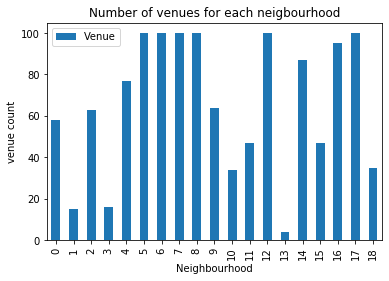

In [25]:
import matplotlib.pyplot as plt

ax =dt_venues.plot.bar()
plt.title('Number of venues for each neigbourhood')
plt.ylabel('venue count')
plt.xlabel('Neighbourhood')

## Analyze Each Neighborhood

In [27]:
# one hot encoding
downtown_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_onehot['Neighbourhood'] = downtown_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [downtown_onehot.columns[-1]] + list(downtown_onehot.columns[:-1])
downtown_onehot = downtown_onehot[fixed_columns]

downtown_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataframe size for downtown_onehot

In [28]:
downtown_onehot.shape

(1242, 210)

###  Next, the dataframe are grouped by neighborhood and mean of the frequency of occurrence of each category

In [34]:
downtown_grouped = downtown_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.017241,0.000000,0.000000,0.000000,0.00,0.000000
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.066667,0.066667,0.133333,0.2,0.066667,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
2,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.015873,0.000000,0.000000,0.015873,0.00,0.015873
3,Christie,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Church and Wellesley,0.012987,0.000000,0.000000,0.000000,0.0,0.000000,0.012987,0.000000,0.00,...,0.012987,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.025974
5,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.040000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.020000,0.000000,0.000000,0.010000,0.00,0.000000
6,"First Canadian Place, Underground city",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.030000,0.000000,0.00,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.00,0.000000
7,"Garden District, Ryerson",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,...,0.000000,0.01,0.00,0.00,0.000000,0.000000,0.010000,0.010000,0.00,0.000000
8,"Harbourfront East, Union Station, Toronto Islands",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.05,...,0.000000,0.00,0.00,0.01,0.010000,0.000000,0.000000,0.010000,0.00,0.000000
9,"Kensington Market, Chinatown, Grange Park",0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.00,0.062500,0.000000,0.046875,0.015625,0.00,0.000000


In [35]:
print('The dataframe size after grouped is', downtown_grouped.shape)

The dataframe size after grouped is (19, 210)


## Get data for neighborhood with both coffee shop and Italian restaurant

In [169]:
downtown_data1 = downtown_grouped[['Neighbourhood','Coffee Shop','Italian Restaurant']]
downtown_data1

,Neighbourhood,Coffee Shop,Italian Restaurant
0,Berczy Park,0.103448,0.017241
1,"CN Tower, King and Spadina, Railway Lands, Har...",0.066667,0.000000
2,Central Bay Street,0.174603,0.047619
3,Christie,0.062500,0.062500
4,Church and Wellesley,0.103896,0.000000
5,"Commerce Court, Victoria Hotel",0.130000,0.030000
6,"First Canadian Place, Underground city",0.120000,0.010000
7,"Garden District, Ryerson",0.080000,0.030000
8,"Harbourfront East, Union Station, Toronto Islands",0.120000,0.020000
9,"Kensington Market, Chinatown, Grange Park",0.062500,0.000000


# 10. Neighbourhood clustering using K-Means

In [171]:
from sklearn.cluster import KMeans

downtown_grouped_clustering = downtown_data1.drop('Neighbourhood', 1)

sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 10):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(downtown_grouped_clustering)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_ 

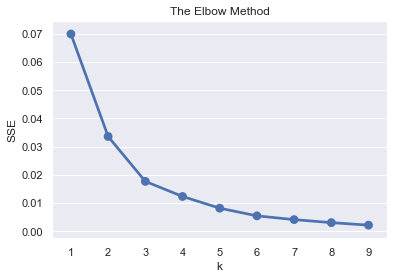

In [172]:
import seaborn as sns

# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
ax.grid()
plt.show()


## Elbow Point Method is used to get optimum K value
### To determine the optimal number of clusters, we have to select the value of k at the point after the line distortion/inertia start to decrease in a linear fashion. The value in our case is K = 3. That means we will have a total of 3 clusters.


In [173]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 2, 0, 2, 2, 2, 0, 2, 0], dtype=int32)

## Create a new dataframe that includes the cluster  for each neighborhood

In [174]:
# add clustering labels
downtown_data1.insert(0, 'Cluster Labels', kmeans.labels_)

#downtown_merged = downtown_data
downtown_merged = downtown_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_merged = downtown_merged.join(downtown_data1.set_index('Neighbourhood'), on='Neighbourhood')

downtown_merged.head() 


,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Coffee Shop,Italian Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,0.170213,0.000000
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,0.264706,0.000000
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.080000,0.030000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.057471,0.022989
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,0.103448,0.017241


In [103]:
downtown_merged.shape

(19, 8)

## Cluster visualization

In [175]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_merged['Latitude'], downtown_merged['Longitude'], \
                                  downtown_merged['Neighbourhood'], downtown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Venue categories for Cluster = 1

In [176]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 0]#red

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Coffee Shop,Italian Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,0.080000,0.030000
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,0.057471,0.022989
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,0.062500,0.062500
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0,0.090000,0.000000
11,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,0,0.028571,0.028571
12,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,0,0.062500,0.000000
13,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420,0,0.066667,0.000000
14,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,0.000000,0.000000
16,M4X,Downtown Toronto,"St. James Town, Cabbagetown",43.667967,-79.367675,0,0.063830,0.042553


## Venue categories for Cluster 2

In [177]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 1]#purple

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Coffee Shop,Italian Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,0.264706,0.0


## Venue categories for Cluster 3

In [178]:
downtown_merged.loc[downtown_merged['Cluster Labels'] == 2]#green

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,Coffee Shop,Italian Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,0.170213,0.000000
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,2,0.103448,0.017241
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,2,0.174603,0.047619
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,2,0.120000,0.020000
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,2,0.130000,0.030000
10,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,2,0.130000,0.030000
15,M5W,Downtown Toronto,Stn A PO Boxes,43.646435,-79.374846,2,0.115789,0.042105
17,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,2,0.120000,0.010000
18,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2,0.103896,0.000000


### Number of neighbourhood for each cluster

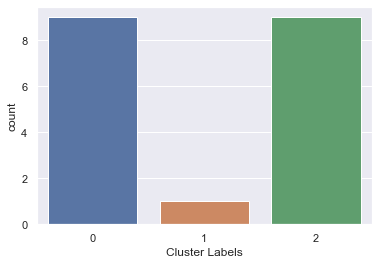

In [108]:
# number of neighbourhood in each cluster

ax = sns.countplot(x='Cluster Labels', data=downtown_merged)


### Mean of Coffee Shop for each cluster

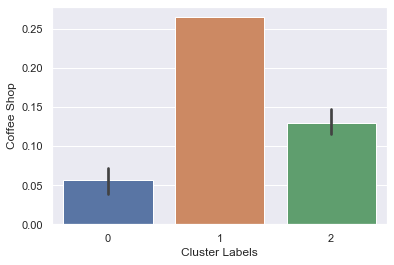

In [125]:
ax = sns.barplot(x='Cluster Labels', y='Coffee Shop', data=downtown_merged)

### Mean of Italian restaurant for each cluster

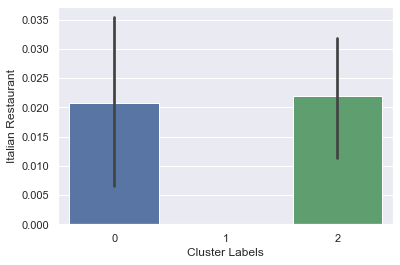

In [126]:
ax = sns.barplot(x='Cluster Labels', y='Italian Restaurant', data=downtown_merged)

In [127]:
downtown_cluster_sum = downtown_merged[['Neighbourhood','Cluster Labels','Coffee Shop','Italian Restaurant']]
downtown_cluster_sum.head()

,Neighbourhood,Cluster Labels,Coffee Shop,Italian Restaurant
0,"Regent Park, Harbourfront",2,0.170213,0.000000
1,"Queen's Park, Ontario Provincial Government",1,0.264706,0.000000
2,"Garden District, Ryerson",0,0.080000,0.030000
3,St. James Town,0,0.057471,0.022989
4,Berczy Park,2,0.103448,0.017241


In [129]:
#Melt the downtown_merged dataframe

downtown_cluster_melt = pd.melt(downtown_cluster_sum, id_vars=['Neighbourhood','Cluster Labels'],\
                                var_name = 'Category', value_name = 'Value')

downtown_cluster_melt.head()

,Neighbourhood,Cluster Labels,Category,Value
0,"Regent Park, Harbourfront",2,Coffee Shop,0.170213
1,"Queen's Park, Ontario Provincial Government",1,Coffee Shop,0.264706
2,"Garden District, Ryerson",0,Coffee Shop,0.080000
3,St. James Town,0,Coffee Shop,0.057471
4,Berczy Park,2,Coffee Shop,0.103448


In [132]:
downtown_cluster_melt.tail()

,Neighbourhood,Cluster Labels,Category,Value
33,Rosedale,0,Italian Restaurant,0.000000
34,Stn A PO Boxes,2,Italian Restaurant,0.042105
35,"St. James Town, Cabbagetown",0,Italian Restaurant,0.042553
36,"First Canadian Place, Underground city",2,Italian Restaurant,0.010000
37,Church and Wellesley,2,Italian Restaurant,0.000000


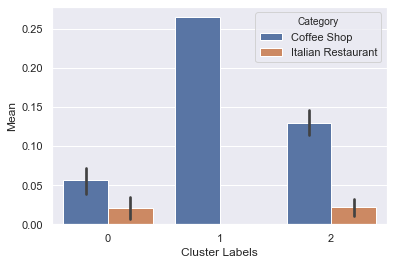

In [136]:
# Rename value to Mean
downtown_cluster_melt.rename(columns ={'Value':'Mean'}, inplace = True)

#Plot bar chart for Mean for each Catgeory in each Cluster
ax = sns.barplot(x='Cluster Labels', y= 'Mean',hue='Category', data=downtown_cluster_melt)